---
title: "Weather-Induced Extremes Digital Twin Series"
subtitle: "his notebook authenticates with the DestinE API, queries ECMWF Extremes Digital Twin forecast data for a user-selected date within the last 14 days, downloads it, and visualizes wind gust and sea-level pressure fields using EarthKit."
author: "Micheal Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)"
tags: [HDA, ECMWF, Authentication, Digital Twin]
thumbnail: ../../img/ECMWF.png
license: MIT
copyright: "© 2025 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/DestinE%20Digital%20Twins/DEDL-HDA-EO.ECMWF.DAT.DT_EXTREMES-Series.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b><ul>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
   <li>To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.</li></ul>
<b> References: </b><ul>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://destine.ecmwf.int/weather-induced-extremes-digital-twin-1/">Weather-Induced Extremes Digital Twin (Extremes DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Extremes+DT+data+catalogue">Extreme DT data catalogue</a></li></ul>
<b> Credit: </b><ul>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li></ul>
</div>


This notebook demonstrates how to use the **HDA (Harmonized Data Access)** API to query and access Extremes DT data to plot a parameter.
Below the main steps covered by this tutorial.

1. [Setup](#DEDL-HDA-EO.ECMWF.DAT.DT_EXTREMES-Series.ipynb-Setup): Import the required libraries. 
2. [Order and Download](#DEDL-HDA-EO.ECMWF.DAT.DT_EXTREMES-Series.ipynb-Order-and-Download): How to filter and download Extremes DT data series.
3. [Plot](#DEDL-HDA-EO.ECMWF.DAT.DT_EXTREMES-Series.ipynb-Render-the-variables-on-a-map): How to visualize hourly data on single levels data through Earthkit.

(DEDL-HDA-EO.ECMWF.DAT.DT_EXTREMES-Series.ipynb-Setup)=
# Setup

Import all the required packages.

In [1]:
import destinelab as deauth
import json
import datetime
import importlib.metadata

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
from getpass import getpass
from tqdm import tqdm
import time
from datetime import datetime
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON
import ipywidgets as widgets

(DEDL-HDA-EO.ECMWF.DAT.DT_EXTREMES-Series.ipynb-Order-and-Download)=
# Order and Download

## Obtain Authentication Token

To access data we need to be authenticated. 

Below how to request of an authentication token using the destinelab package.

In [2]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


#### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [3]:
import importlib
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## HDA Endpoint
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC), it is convenient define a costant with its endpoint.
And another one with the ID of the Cliamte DT collection.

In [4]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID="EO.ECMWF.DAT.DT_EXTREMES"

## Order and download data

Weather-Induced Extremes Digital Twin collection, as well as all the ECMWF datasets, in the DestinE Data Lake requires an ordering workflow. 
The ordering workflow consists of the following steps:
- submit an order with parameters directly to the collection,
- monitor the returned STAC item status,
- download the asset when ready.

Note:
ECMWF data follows this process, the STAC item in this case will always contain one asset with the requested data.

### Extreme DT data availability

Extreme DT data is available for specific time ranges (last 14 days) around the current date.

It is possible to use the ECMWF Aviso package to check data availability in the last 14 days (see https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/HDA/DestinE%20Digital%20Twins/ExtremeDT-dataAvailability.ipynb or https://github.com/destination-earth-digital-twins/aviso-examples/blob/main/aviso-extremes-dt.py) and request data accordingly.

In [5]:
from datetime import datetime, timedelta

# Get the current date and time in UTC
current_date = datetime.utcnow()

# Calculate the date 14 days before the current date
date_14_days_ago = current_date - timedelta(days=14)

# Format the date as YYYYMMDD and set the time to 0000 UTC
formatted_date = date_14_days_ago.strftime('%Y%m%d') + '0000'
# Convert the formatted date back to a datetime object
date_from = datetime.strptime(formatted_date, '%Y%m%d%H%M%S').date()

# Format the date as YYYYMMDD and set the time to 0000 UTC
formatted_date = current_date.strftime('%Y%m%d') + '0000'
# Convert the formatted date back to a datetime object
date_to = datetime.strptime(formatted_date, '%Y%m%d%H%M%S').date()



In [6]:
start_date_picker = widgets.DatePicker(description='Start Date:', disabled=False)

# Set initial values directly
start_date_picker.min = date_from
start_date_picker.max = date_to
start_date_picker.value = date_from

def get_selected_values():
    selected_start_date = start_date_picker.value
    return selected_start_date

# Display widgets
display(start_date_picker)

DatePicker(value=datetime.date(2025, 10, 7), description='Start Date:', max=datetime.date(2025, 10, 21), min=d…

In [7]:
# Example usage:
datechoice =  get_selected_values().strftime("%Y%m%d")
#print(datechoice)
filter_params = {
        "ecmwf:class": "d1",             # fixed (rd or d1)
        "ecmwf:dataset": "extremes-dt",  # fixed extreme dt 
        "ecmwf:expver": "0001",          # fixed experiment version 
        "ecmwf:stream": "oper",          # fixed oper
        "ecmwf:step": "0/6/12/18/24",    # Forcast step hourly (1..96)
        "ecmwf:type": "fc",              # fixed forecasted fields
        "ecmwf:levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "ecmwf:param": "151/228029",     # 10m Wind gust & Mean Sea Level Pressure
        "ecmwf:date":datechoice+"/to/"+datechoice
}

In [8]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=filter_params, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")      

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

Product ordered: 2186cd55-86e1-4ffd-b56c-4b6af514a087
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: shipping


### Monitor the status

The status of an order can be:
- shipping, that means that the order is in progress;
- succeeded, that means that the order is completed;
- failed, that means that the order is in error.

In [9]:
for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break
    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()


Polling 1/300
Polling 2/300
Polling 3/300
Polling 4/300
Product is ready to be downloaded.
Asset URL: https://hda-download.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.DT_EXTREMES/2186cd55-86e1-4ffd-b56c-4b6af514a087/downloadLink


### Download

In [10]:

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 2186cd55-86e1-4ffd-b56c-4b6af514a087.grib


531MB [00:59, 8.98MB/s] 


(DEDL-HDA-EO.ECMWF.DAT.DT_EXTREMES-Series.ipynb-Render-the-variables-on-a-map)=
## Render the variables on a map

Lets plot the result file

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [11]:
import earthkit.data
import earthkit.maps

data = earthkit.data.from_source("file", filename)
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,msl,meanSea,0,20251021,0,0,fc,None,reduced_gg
1,ecmf,i10fg,heightAboveGround,10,20251021,0,0,fc,None,reduced_gg
2,ecmf,msl,meanSea,0,20251021,0,6,fc,None,reduced_gg
3,ecmf,i10fg,heightAboveGround,10,20251021,0,6,fc,None,reduced_gg
4,ecmf,msl,meanSea,0,20251021,0,12,fc,None,reduced_gg
5,ecmf,i10fg,heightAboveGround,10,20251021,0,12,fc,None,reduced_gg
6,ecmf,msl,meanSea,0,20251021,0,18,fc,None,reduced_gg
7,ecmf,i10fg,heightAboveGround,10,20251021,0,18,fc,None,reduced_gg
8,ecmf,msl,meanSea,0,20251021,0,24,fc,None,reduced_gg
9,ecmf,i10fg,heightAboveGround,10,20251021,0,24,fc,None,reduced_gg


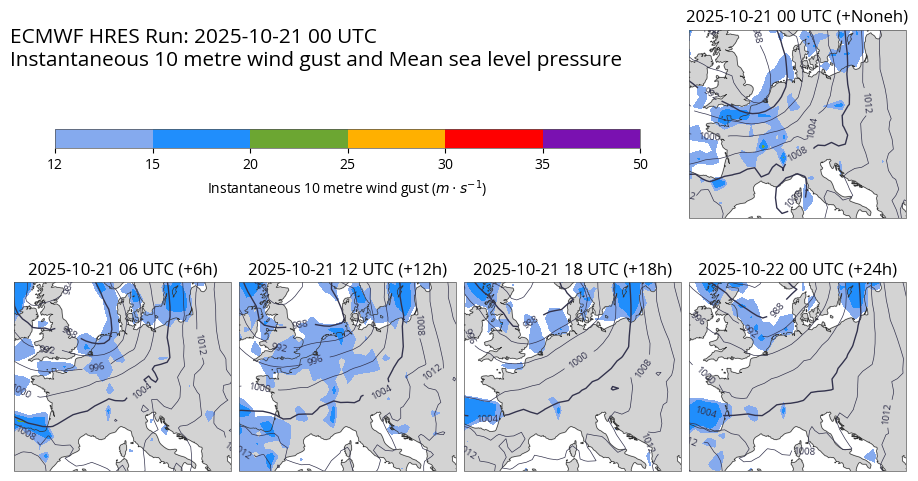

In [12]:
import matplotlib.pyplot as plt

chart = earthkit.maps.Chart(domain=[-5, 23, 40, 58], rows=3, columns=4)

gust_style = earthkit.maps.Style(
    colors=["#85AAEE", "#208EFC", "#6CA632", "#FFB000", "#FF0000", "#7A11B1"],
    levels=[12, 15, 20, 25, 30, 35, 50],
    units="m s-1",
)

chart.add_subplot(row=0, column=3)
for i in range(4):
    chart.add_subplot(row=1+i//4, column=i%4)

chart.plot(data.sel(shortName="i10fg"), style=gust_style)
chart.plot(data.sel(shortName="msl"), units="hPa")

chart.land(color="lightgrey")
chart.coastlines()

ax = plt.axes((0.05, 0.8, 0.65, 0.025))
chart.legend(ax=ax)

chart.subplot_titles("{time:%Y-%m-%d %H} UTC (+{lead_time}h)")
chart.title(
    "ECMWF HRES Run: {base_time:%Y-%m-%d %H} UTC\n{variable_name}",
    fontsize=15, horizontalalignment="left", x=0, y=0.96,
)

chart.show()